# Customer Churn Prediction Project

**Author** : Jahleel Jackson

**Date Completed**: 

**Purpose** : Conducting exploratory data analysis and model building to predict whether a customer will decide leave an internet service. 

For the original dataset click, [here](https://www.kaggle.com/datasets/abdullah0a/telecom-customer-churn-insights-for-analysis/data).

Feature Descriptions:
- CustomerID: Unique identifier for each customer.
- Age: Age of the customer, reflecting their demographic profile.
- Gender: Gender of the customer (Male or Female).
- Tenure: Duration (in months) the customer has been with the service provider.
- MonthlyCharges: The monthly fee charged to the customer.
- ContractType: Type of contract the customer is on (Month-to-Month, One-Year, Two-Year).
- InternetService: Type of internet service subscribed to (DSL, Fiber Optic, None).
- TechSupport: Whether the customer has tech support (Yes or No).
- TotalCharges: Total amount charged to the customer (calculated as MonthlyCharges * Tenure).
- Churn: Target variable indicating whether the customer has churned (Yes or No).


In [1]:
import sys 
print('Python Version: {}'.format(sys.version[:6]))

Python Version: 3.13.0


In [2]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import warnings
warnings.filterwarnings('ignore')

In [3]:
#Reading in data
file = 'customer_churn_data.csv'
df = pd.read_csv(file)
df.head()

,CustomerID,Age,Gender,Tenure,MonthlyCharges,ContractType,InternetService,TotalCharges,TechSupport,Churn
0,1,49,Male,4,88.35,Month-to-Month,Fiber Optic,353.40,Yes,Yes
1,2,43,Male,0,36.67,Month-to-Month,Fiber Optic,0.00,Yes,Yes
2,3,51,Female,2,63.79,Month-to-Month,Fiber Optic,127.58,No,Yes
3,4,60,Female,8,102.34,One-Year,DSL,818.72,Yes,Yes
4,5,42,Male,32,69.01,Month-to-Month,NaN,2208.32,No,Yes


## Exploratory Data Analysis

In [4]:
df.info()
#1000 instances, 9 features + 1 target variable 'Churn'
#'InternetService' is the only column with missing data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerID       1000 non-null   int64  
 1   Age              1000 non-null   int64  
 2   Gender           1000 non-null   object 
 3   Tenure           1000 non-null   int64  
 4   MonthlyCharges   1000 non-null   float64
 5   ContractType     1000 non-null   object 
 6   InternetService  703 non-null    object 
 7   TotalCharges     1000 non-null   float64
 8   TechSupport      1000 non-null   object 
 9   Churn            1000 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 78.3+ KB


In [11]:
#Viewing if there are duplicates
df.duplicated().sum()
#There are none

np.int64(0)

In [12]:
df.describe()
# IQRs for Age and Tenure are 38-51 years old and 5-26 months respectively 
# With the 'Tenure' column having both a mean and standard deviation nearing 19, we know that there is a diverse range of tenure lengths in this dataset
# Plans range from $30/month to $120/month

,CustomerID,Age,Tenure,MonthlyCharges,TotalCharges
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,500.500000,44.674000,18.97300,74.391290,1404.364060
std,288.819436,9.797741,18.89257,25.712083,1571.755048
min,1.000000,12.000000,0.00000,30.000000,0.000000
25%,250.750000,38.000000,5.00000,52.357500,345.217500
50%,500.500000,45.000000,13.00000,74.060000,872.870000
75%,750.250000,51.000000,26.00000,96.102500,1900.175000
max,1000.000000,83.000000,122.00000,119.960000,12416.250000


In [13]:
#Creating a numeric table of the data to view correlations
numeric_df = df.select_dtypes(include = 'number').corr().drop('CustomerID', axis = 0).drop('CustomerID', axis = 1) #Dropping 'Customer ID' from correlational table
numeric_df

,Age,Tenure,MonthlyCharges,TotalCharges
Age,1.000000,0.000472,0.006362,-0.001896
Tenure,0.000472,1.000000,-0.014552,0.894868
MonthlyCharges,0.006362,-0.014552,1.000000,0.304893
TotalCharges,-0.001896,0.894868,0.304893,1.000000


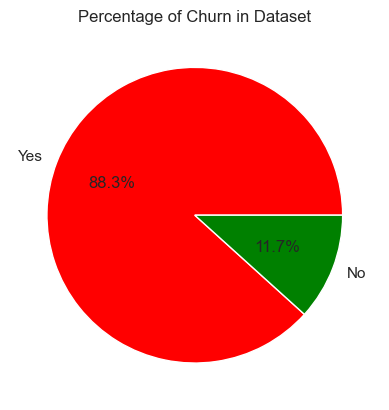

<Figure size 640x480 with 0 Axes>

In [14]:
#Creating pie chart to view does churn vs. does not churn proportions
colors = ['red', 'green']
df.Churn.value_counts().plot(kind = 'pie', colors = colors, autopct = '%1.1f%%')
plt.title('Percentage of Churn in Dataset')
plt.ylabel('') #To remove the ylabel's default 'count' that appears
plt.show()
plt.savefig('churn_ratio.png')
#This dataset is heavily biased towards churning customers

In [15]:
#Seeing the average monthly cost for churning and non-churning customers
churn_monthly_avg = df.groupby('Churn')['MonthlyCharges'].mean()
churn_monthly_avg
#From this we can see that those who leave a service pay more per month on average than those who do not leave.

Churn
No     62.54641
Yes    75.96077
Name: MonthlyCharges, dtype: float64

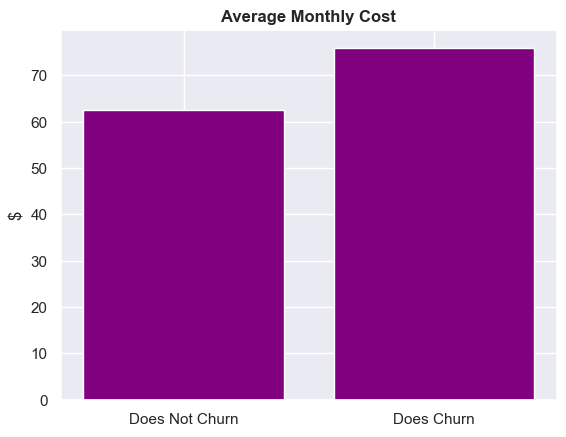

In [25]:
#Plotting Data
categories = ['Does Not Churn', 'Does Churn']
values = list(churn_monthly_avg.values)
plt.bar(categories, values, color = 'purple')
plt.title('Average Monthly Cost', fontweight = 'bold')
plt.ylabel('$')
plt.savefig('plots/avg_monthly.png', bbox_inches = 'tight')
plt.show()

In [21]:
#Viewing what contracts are typical of churning and non-churning customers
df.groupby('Churn')['ContractType'].value_counts()
#This is interesting, there is a disproportionate amount of churning customers who initially had month-to-month plans.
#There are no customers with month-to-month contractions that stay. 

Churn  ContractType  
No     One-Year           71
       Two-Year           46
Yes    Month-to-Month    511
       One-Year          218
       Two-Year          154
Name: count, dtype: int64

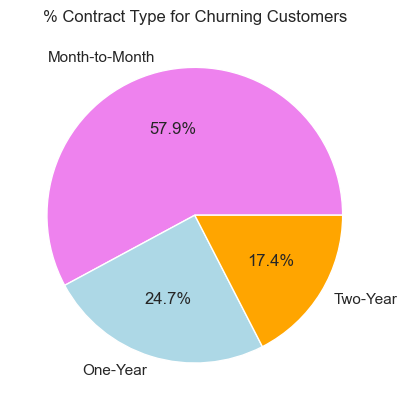

In [26]:
#Plotting data for churning customer contract types
colors = ['violet', 'lightblue', 'orange']
df.groupby('Churn')['ContractType'].value_counts()['Yes'].plot(kind = 'pie', autopct = '%1.1f%%', colors = colors)
plt.title('% Contract Type for Churning Customers')
plt.ylabel('')
plt.savefig('plots/churning_pie.png', bbox_inches = 'tight')
plt.show()
#As we can see, more than half of contract types by churning customers are month-to-month

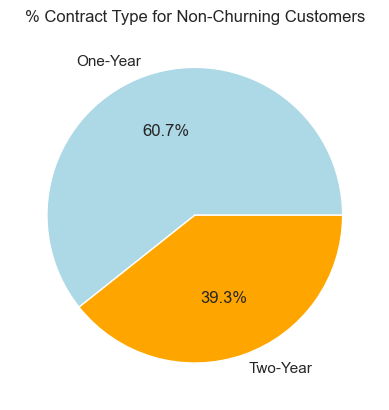

In [27]:
#Plotting data for non-churning customer contract types
colors = ['lightblue', 'orange']
df.groupby('Churn')['ContractType'].value_counts()['No'].plot(kind = 'pie', autopct = '%1.1f%%', colors = colors)
plt.title('% Contract Type for Non-Churning Customers')
plt.ylabel('')
plt.savefig('plots/nonchurning_pie.png', bbox_inches = 'tight')
plt.show()
#Not only are there no month-to-month contract types for non-churning customers, but there is an even larger ratio of one-year contracts to two-year contracts

In [24]:
#Viewing the internet service value counts in relation to churn
internet_churn = df.groupby('InternetService')['Churn'].value_counts()
internet_churn

InternetService  Churn
DSL              Yes      260
                 No        48
Fiber Optic      Yes      326
                 No        69
Name: count, dtype: int64

Text(0.5, 1.0, 'Percentage of Fiber Optic Customers Churning')

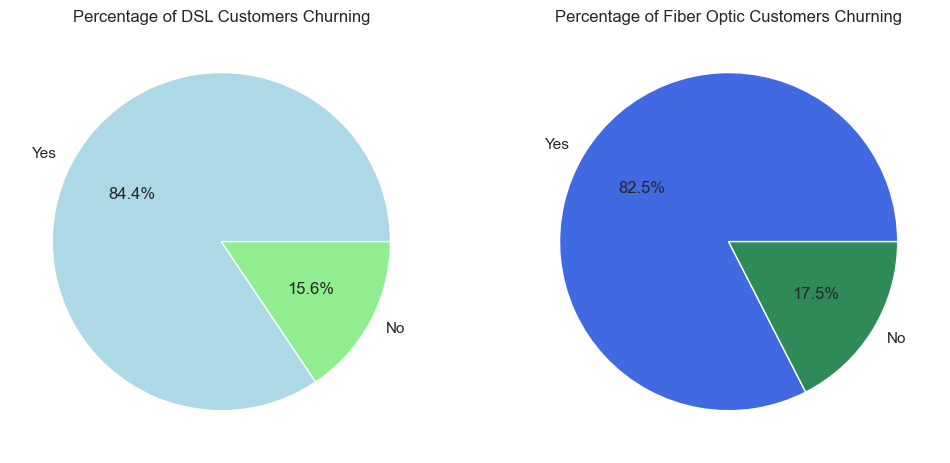

In [44]:
#Plotting churning rates of respective internet services
categories = ['Yes', 'No']
dsl_values = list(internet_churn.DSL.values)
fiber_values = list(internet_churn['Fiber Optic'].values)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))

ax1.pie(dsl_values, labels = categories, autopct = '%1.1f%%', colors = ['lightblue', 'lightgreen'])
ax1.set_title('Percentage of DSL Customers Churning')

ax2.pie(fiber_values, labels = categories, autopct = '%1.1f%%', colors = ['royalblue', 'seagreen'])
ax2.set_title('Percentage of Fiber Optic Customers Churning')
#There is no signficant difference in churning rates between the two internet services

## Feature Engineering

In [45]:
df.columns
#After exploring the dataset, I will now split the data into X (predictive features) and y (target variable)

Index(['CustomerID', 'Age', 'Gender', 'Tenure', 'MonthlyCharges',
       'ContractType', 'InternetService', 'TotalCharges', 'TechSupport',
       'Churn'],
      dtype='object')

In [46]:
#Splitting data
X = df[['Age', 'Gender', 'Tenure', 'MonthlyCharges', 'ContractType', 'TotalCharges']]
y = df['Churn']

In [47]:
#Encoding the 'Gender' feature
X['Gender'] = X['Gender'].apply(lambda x: 1 if x == 'Male' else 0)
X['Gender']

0      1
1      1
2      0
3      0
4      1
      ..
995    1
996    1
997    0
998    1
999    1
Name: Gender, Length: 1000, dtype: int64

In [48]:
#One hot encoding the 'ContractType' feature
contract_ohe = pd.get_dummies(X['ContractType']).astype('int')
contract_ohe.head()

,Month-to-Month,One-Year,Two-Year
0,1,0,0
1,1,0,0
2,1,0,0
3,0,1,0
4,1,0,0


In [49]:
#Concatenating one hot encoding dataframe with our current X while dropping 'ContractType' column
X = pd.concat([X.drop('ContractType', axis = 1), contract_ohe], axis = 1)
X.head()

,Age,Gender,Tenure,MonthlyCharges,TotalCharges,Month-to-Month,One-Year,Two-Year
0,49,1,4,88.35,353.40,1,0,0
1,43,1,0,36.67,0.00,1,0,0
2,51,0,2,63.79,127.58,1,0,0
3,60,0,8,102.34,818.72,0,1,0
4,42,1,32,69.01,2208.32,1,0,0


In [50]:
#Encoding the target variable
y = y.apply(lambda x: 1 if x == 'Yes' else 0)
y.head()

0    1
1    1
2    1
3    1
4    1
Name: Churn, dtype: int64

In [51]:
#Further splitting into train and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)

In [52]:
#Import StandardScaler to scale our data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

In [53]:
#Saving our scaler object in a file
import joblib
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

## Model Building

In [54]:
X_test = scaler.fit_transform(X_test)

In [55]:
#Creating function to return print statement of model performance
from sklearn.metrics import accuracy_score

def modelperformance(prediction) :
    print('Accuracy of model: {:.2f}%'.format(accuracy_score(y_test, prediction) * 100))

In [56]:
#Importing GridSearchCV for hyperparamter tuning
from sklearn.model_selection import GridSearchCV

In [57]:
#Importing logistic regression model
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression()

In [58]:
param_grid = {
    'penalty' : ['l1', 'l2'],
    'C' : [0.01, 0.1, 1, 10],
    'max_iter' : [50, 100, 200]
}

In [59]:
grid_lr = GridSearchCV(log_model, param_grid, cv = 5)
grid_lr.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10], 'max_iter': [50, 100, 200],
                         'penalty': ['l1', 'l2']})

In [60]:
#Assigning our prediction array to y_pred
y_pred = grid_lr.predict(X_test)
modelperformance(y_pred)

Accuracy of model: 86.00%


In [61]:
#Importing KNN model
from sklearn.neighbors import KNeighborsClassifier

In [62]:
#Creating parameter grid for hyperparameter tuning
param_grid = {
    'n_neighbors' : [3, 5, 7],
    'weights' : ['uniform', 'distance']
}

In [63]:
#Creating GridSearchCV object
gridkn = GridSearchCV(KNeighborsClassifier(), param_grid, cv = 5)

In [64]:
#Fitting data to GridSearchCV object
gridkn.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7],
                         'weights': ['uniform', 'distance']})

In [65]:
gridkn.best_params_
#Our best performing parameters were 5 neighbors and a distance-based weighting system

{'n_neighbors': 5, 'weights': 'uniform'}

In [66]:
#Predicting with best performing parameters
y_pred = gridkn.predict(X_test)
modelperformance(y_pred)

Accuracy of model: 87.00%


In [67]:
#Importing Support Vector Machine classification model and setting parameter grid
from sklearn.svm import SVC
param_grid = {
        'C' : [0.01, 0.1, 1],
        'kernel' : ['linear', 'rbf', 'poly']
}

In [68]:
#Creating GridSearchCV object for SVM model
gridsvc = GridSearchCV(SVC(), param_grid, cv = 5)

In [69]:
#Fitting data to GridSearchCV object
gridsvc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1],
                         'kernel': ['linear', 'rbf', 'poly']})

In [70]:
gridsvc.best_params_

{'C': 1, 'kernel': 'rbf'}

In [71]:
#Prediction churn with best parameter svm model
y_pred = gridsvc.predict(X_test)
modelperformance(y_pred)

Accuracy of model: 84.00%


In [72]:
#Importing decision tree classification model and setting parameter grid
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'criterion' : ['gini', 'entropy'],
    'splitter' : ['best', 'random'],
    'max_depth' : [None, 10, 20, 30],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf' : [1, 2, 4]
}

In [73]:
#Initializing GridSearchCV object with decision tree classification model and parameters
gridtc = GridSearchCV(DecisionTreeClassifier(), param_grid, cv = 5) 

In [74]:
#Fitting data to GridSearchCV
gridtc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [75]:
gridtc.best_params_

{'criterion': 'gini',
 'max_depth': 20,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'splitter': 'best'}

In [76]:
#Printing accuracy of prediction
y_pred = gridtc.predict(X_test)
modelperformance(y_pred)

Accuracy of model: 87.00%


In [77]:
#Importing Random Forest Classification model and setting parameter grid
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

param_grid = {
    'n_estimators' : [32, 64, 128],
    'max_features' : [2, 3, 4],
    'bootstrap' : [True, False]
}

In [78]:
#Initializing GridSearchCV object with random foreset classification model and fitting to data
grid_rfc = GridSearchCV(rfc, param_grid, cv = 5) 
grid_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False], 'max_features': [2, 3, 4],
                         'n_estimators': [32, 64, 128]})

In [79]:
grid_rfc.best_params_

{'bootstrap': True, 'max_features': 4, 'n_estimators': 32}

In [80]:
#Printing accuracy of random forest model
y_pred = grid_rfc.predict(X_test)
modelperformance(y_pred)

Accuracy of model: 89.50%


Our best model performing model was the random forest classification model with an accuracy of 89.5%. Best parameters were:
- 'criterion' : 'entropy'
- 'max_depth' : None
- 'min_samples_leaf' : 4
- 'min_samples_split' : 2
- 'splitter' : 'best'

In [87]:
best_model = grid_rfc.best_estimator_

In [88]:
#Saving best model to file
joblib.dump(best_model, 'model.pkl')

['model.pkl']